## Валидация генерации (упрощенная модель без spacial)

(итоговые функции перенесены в library/metrics.py и library/metrics_pseudo.py)

### Почему именно такие метрики выбраны и почему не подходят другие

 1. Можно сравнивать генерацию и GT на основе метрики **ROUGE** или **ROUGE-N** (превращаем наше json описание в текст и сравниваем тексты), но это будет работать плохо потому что будет зависеть например от порядка признаков в описании объекта при обратном отображении json -> text ну и как-то нелогично для сравнения более компактную структуру разворачивать в структуру с большим числом степеней свободы и потмо сравнивать. Очень шумная метрика будет
<br><br>
 2. **BLEU** (Bilingual Evaluation Understudy) тоже совсем плохо подходит к задаче оценки извлечения объектов и признаков, потому что не учитывает структуру, чувствителен к порядку, сложно интерпретируется.
<br><br>
 3. **GED** (Graph Edit Distance) — это мера "расстояния" между двумя графами, равная минимальной стоимости преобразований (добавление/удаление/замена узлов и рёбер), необходимых для превращения одного графа в другой.в текущей постановке избыточна, но если строить реальные сценовые графы (с добавлением пространственных связей между объектами) была бы полезна

In [1]:
from typing import List, Dict, Tuple
from collections import Counter
import numpy as np
import spacy

# Загружаем русскую модель spaCy
nlp = spacy.load("ru_core_news_sm")

In [2]:
pred = [
    {"гаечный ключ": ["металлический"]},
    {"домкрат": ["металлический", "тяжелый"]},
    {"аккумулятор": []}
]

label = [
    {"гаечный ключ": ["металлический"]},
    {"домкрат": ["металлический", "тяжелый", "прочный"]},
    {"аккумулятор": []}
]

## Предварительная нормализация

сгенерированный json может включать в себя слова в разных формах, поэтому для того чтобы это разнообразие не сказывалось на теккщей оценке считаю нужным лемматизировать все слова в json, как в сгенерированном так и в эталонном

## Используемые метрики

### f1_objects

Стандартная f1 по объектам. Метрика оценивает, насколько хорошо предсказаны имена объектов независимо от их признаков.

(**тут я потом напишу кучу красивых формул в маркдауне**)

In [ ]:
        "f1_objects": round(f1_objects, 4),
        "f1_attributes_macro": round(f1_attributes_macro, 4),
        "f1_attributes_weighted": round(f1_attributes_weighted, 4),
        "f1_global_obj_attr_pairs": round(f1_global_pairs, 4),
        "f1_combined_simple": round(f1_combined_simple, 4),
        "f1_combined_weighted": round(f1_combined_weighted, 4),

Простое объединение (f1_combined_simple)

Простое среднее между F1 по объектам и F1 по признакам (macro):



In [3]:
# Загружаем модель spaCy для русского языка
nlp = spacy.load("ru_core_news_sm")

def lemmatize_phrase_spacy(phrase: str) -> str:
    """Лемматизирует фразу с помощью spaCy (только леммы, без пунктуации)."""
    doc = nlp(phrase.lower())
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

def normalize_structure(data: List[Dict[str, List[str]]]) -> Dict[str, List[str]]:
    """Преобразует список словарей в один словарь с лемматизированными объектами и признаками."""
    result = {}
    for obj_dict in data:
        for obj, attrs in obj_dict.items():
            obj_lemma = lemmatize_phrase_spacy(obj)
            attr_lemmas = [lemmatize_phrase_spacy(attr) for attr in attrs]
            result.setdefault(obj_lemma, []).extend(attr_lemmas)
    # Удалим дубли
    result = {k: list(set(v)) for k, v in result.items()}
    return result

def precision_recall_f1(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

def evaluate_all_metrics(pred_raw: List[Dict[str, List[str]]], label_raw: List[Dict[str, List[str]]]) -> Dict[str, float]:
    pred = normalize_structure(pred_raw)
    label = normalize_structure(label_raw)

    # F1 по объектам
    pred_objects = set(pred.keys())
    label_objects = set(label.keys())
    tp_obj = len(pred_objects & label_objects)
    fp_obj = len(pred_objects - label_objects)
    fn_obj = len(label_objects - pred_objects)
    _, _, f1_objects = precision_recall_f1(tp_obj, fp_obj, fn_obj)

    # F1 по признакам по каждому объекту (усреднение по объектам, macro)
    f1_per_object = []
    total_attrs = 0
    weighted_sum = 0
    for obj in label_objects | pred_objects:
        label_attrs = set(label.get(obj, []))
        pred_attrs = set(pred.get(obj, []))
        tp = len(label_attrs & pred_attrs)
        fp = len(pred_attrs - label_attrs)
        fn = len(label_attrs - pred_attrs)
        _, _, f1 = precision_recall_f1(tp, fp, fn)
        f1_per_object.append(f1)
        weighted_sum += f1 * len(label_attrs)
        total_attrs += len(label_attrs)

    f1_attributes_macro = sum(f1_per_object) / len(f1_per_object) if f1_per_object else 0.0
    f1_attributes_weighted = weighted_sum / total_attrs if total_attrs > 0 else 0.0

    # Глобальный F1 по парам (obj, attr)
    pred_pairs = {(obj, attr) for obj, attrs in pred.items() for attr in attrs}
    label_pairs = {(obj, attr) for obj, attrs in label.items() for attr in attrs}
    tp_pairs = len(pred_pairs & label_pairs)
    fp_pairs = len(pred_pairs - label_pairs)
    fn_pairs = len(label_pairs - pred_pairs)
    _, _, f1_global_pairs = precision_recall_f1(tp_pairs, fp_pairs, fn_pairs)

    # Объединённые метрики
    f1_combined_simple = (f1_objects + f1_attributes_macro) / 2
    total_obj = len(label_objects)
    f1_combined_weighted = ((total_obj * f1_objects) + (total_attrs * f1_attributes_weighted)) / (total_obj + total_attrs) if (total_obj + total_attrs) > 0 else 0.0

    return {
        "f1_objects": round(f1_objects, 4),
        "f1_attributes_macro": round(f1_attributes_macro, 4),
        "f1_attributes_weighted": round(f1_attributes_weighted, 4),
        "f1_global_obj_attr_pairs": round(f1_global_pairs, 4),
        "f1_combined_simple": round(f1_combined_simple, 4),
        "f1_combined_weighted": round(f1_combined_weighted, 4),
    }


In [4]:
evaluate_all_metrics(pred, label)

{'f1_objects': 1.0,
 'f1_attributes_macro': 0.6,
 'f1_attributes_weighted': 0.85,
 'f1_global_obj_attr_pairs': 0.8571,
 'f1_combined_simple': 0.8,
 'f1_combined_weighted': 0.9143}

### Тестовый пример

In [24]:
def lemmatize_spacy(text: str) -> str:
    """
    Лемматизирует отдельное слово или фразу (берёт первую лемму из анализа spaCy).
    """
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def normalize_scene_json_spacy(scene_json: Dict) -> Dict:
    """
    Возвращает новый JSON, где все объекты и признаки лемматизированы через spaCy.
    """
    normalized_scene = {"scene": {"location": scene_json["scene"].get("location", ""), "objects": []}}
    for obj_dict in scene_json["scene"]["objects"]:
        for obj_name, attributes in obj_dict.items():
            obj_lemma = lemmatize_spacy(obj_name)
            attr_lemmas = [lemmatize_spacy(attr) for attr in attributes]
            normalized_scene["scene"]["objects"].append({obj_lemma: attr_lemmas})
    return normalized_scene

# Проверим на нашем примере
normalized_gt = normalize_scene_json_spacy(gt)
normalized_pred = normalize_scene_json_spacy(pred)


## Метрики на основе F1-score



### evaluate_scene_extraction()

Считает:

 - F1 по объектам
 - F1 по признакам (в виде пар "объект-признак") 
 - Усреднение F1 по объектам и признакам (по каждому объекту считаем F1 для признаков и усредняем)
 - Взвешенное среднее  по количеству
 
 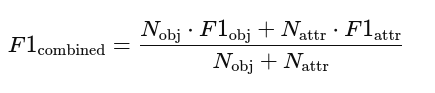

In [25]:
def extract_objects_and_attributes(scene_json: Dict) -> Tuple[List[str], List[Tuple[str, str]]]:
    """
    Извлекает список объектов и список (объект, признак) пар из JSON сцены.
    """
    objects = []
    object_attributes = []
    for obj_dict in scene_json["scene"]["objects"]:
        for obj, attrs in obj_dict.items():
            objects.append(obj)
            for attr in attrs:
                object_attributes.append((obj, attr))
    return objects, object_attributes


def precision_recall_f1(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
    """
    Вычисляет precision, recall и F1.
    """
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1


def evaluate_scene_extraction(gt_json: Dict, pred_json: Dict) -> Dict[str, float]:
    # Извлекаем объекты и признаки
    gt_objects, gt_pairs = extract_objects_and_attributes(gt_json)
    pred_objects, pred_pairs = extract_objects_and_attributes(pred_json)

    # F1 по объектам
    gt_object_set = set(gt_objects)
    pred_object_set = set(pred_objects)
    tp_obj = len(gt_object_set & pred_object_set)
    fp_obj = len(pred_object_set - gt_object_set)
    fn_obj = len(gt_object_set - pred_object_set)
    _, _, f1_object = precision_recall_f1(tp_obj, fp_obj, fn_obj)

    # F1 по (объект, атрибут) парам
    gt_pair_set = set(gt_pairs)
    pred_pair_set = set(pred_pairs)
    tp_attr = len(gt_pair_set & pred_pair_set)
    fp_attr = len(pred_pair_set - gt_pair_set)
    fn_attr = len(gt_pair_set - pred_pair_set)
    _, _, f1_attr = precision_recall_f1(tp_attr, fp_attr, fn_attr)

    # Взвешенное объединение
    f1_combined_weighted = (
        (len(gt_object_set) * f1_object + len(gt_pair_set) * f1_attr)
        / (len(gt_object_set) + len(gt_pair_set))
        if (len(gt_object_set) + len(gt_pair_set)) > 0
        else 0.0
    )
    
    # Простое среднее
    f1_combined_simple = (f1_object + f1_attr) / 2

    return {
        "f1_object": f1_object,
        "f1_attribute": f1_attr,
        "f1_combined_weighted": f1_combined_weighted,
        "f1_combined_simple": f1_combined_simple,
    }


### evaluate_global_f1_on_pairs

```
Пусть:

    GG — множество эталонных пар (объект, признак)
    PP — множество предсказанных пар

Вычисляются:

    TP = ∣G ∩ P∣ — правильно предсказанные пары
    FP = ∣P ∖ G∣ — пары, которых не было в эталоне
    FN = ∣G ∖ P∣ — пары, которые были в эталоне, но не найдены
    
    далее все по стандартным формулам
```



In [26]:
def evaluate_global_f1_on_pairs(gt_json: Dict, pred_json: Dict) -> Dict[str, float]:
    """
    Вычисляет глобальный Precision, Recall и F1 по всем (объект, признак) парам.
    """
    _, gt_pairs = extract_objects_and_attributes(gt_json)
    _, pred_pairs = extract_objects_and_attributes(pred_json)

    gt_pair_set = set(gt_pairs)
    pred_pair_set = set(pred_pairs)

    tp = len(gt_pair_set & pred_pair_set)
    fp = len(pred_pair_set - gt_pair_set)
    fn = len(gt_pair_set - pred_pair_set)

    precision, recall, f1 = precision_recall_f1(tp, fp, fn)

    return {
        "global_precision": precision,
        "global_recall": recall,
        "global_f1": f1,
        "tp": tp,
        "fp": fp,
        "fn": fn
    }



**evaluate_global_f1_on_pairs** удобна для общей проверки фактов, когда не важна структура

**evaluate_scene_extraction** более структурная, если нужно контролировать отдельно объектный и атрибутивный слои.

In [27]:
# Проверим на том же примере
evaluate_global_f1_on_pairs(normalized_gt,normalized_pred)

{'global_precision': 0.6,
 'global_recall': 0.75,
 'global_f1': 0.6666666666666665,
 'tp': 3,
 'fp': 2,
 'fn': 1}

In [28]:
# Оцениваем
evaluate_scene_extraction(normalized_gt,normalized_pred)

{'f1_object': 0.8571428571428571,
 'f1_attribute': 0.6666666666666665,
 'f1_combined_weighted': 0.748299319727891,
 'f1_combined_simple': 0.7619047619047619}